In [2]:
import numpy as np
from collections import OrderedDict

In [3]:

def MaxMinNormalization(x):
    """
    线性归一化，将输入list归一化
    :param x: list类型
    :return: 归一化list
    """
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x


def normalization(list):
    """
    归一化接口，目前只支持线性归一化
    :param list: 矩阵形式
    :return: 归一化矩阵
    """
    out = []
    for x in list:
        out.append(MaxMinNormalization(x))
    return out


def get_max(list):
    """
    提取音频序列中的极大值特征
    :param list，宽度固定为20维，长度不限
    :return:20维数组
    """
    average = []
    arr_temp = np.array(list)
    # arr_temp=np.dot(arr_temp,arr_temp.T)
    for a in arr_temp:
        average.append(max(a))
    # average.append(math.atan(max(a)) * 2 / 3.1415926)
    return average

def load(file):
    """
    输入文件名，加载数据
    :param file:文件名
    :return:浮点型数组
    """
    list = []
    f = open(file, 'r', encoding='UTF-8')
    for line in f:
        line_list = line.replace(',\n', '').split(',')
        for i in range(len(line_list)):
            line_list[i] = float(line_list[i])
        list.append(line_list)
        list = normalization(list)
    return np.array(list)


def load_y(file):
    """
    输入文件名，加载数据
    :param file:文件名
    :return:浮点型数组
    """
    list = []
    f = open(file, 'r', encoding='UTF-8')
    for line in f:
        list.append(np.int64(line))
    return np.array(list)

In [10]:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
X = load('data/x.txt')
y = load('data/y.txt')

new_y = []
for item in y:
    new_y.append(np.argmax(item))
    
y = np.array(new_y)

print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)
print(X_test.shape)
print(y_test.shape)
print(X[-1, ])

(364, 20)
(364,)
(91, 20)
(91,)
[0.         1.         0.7439373  0.81523204 0.68245398 0.63583235
 0.56919546 0.63004358 0.51317874 0.5784048  0.56526871 0.54378003
 0.53581913 0.51616541 0.51459717 0.52425463 0.49956383 0.50344389
 0.51078665 0.51413449]


In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(273, 20)
(273,)
(91, 20)
(91,)


In [12]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy




In [13]:

class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

### Affine 层

In [14]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        # 对应张量
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx


In [15]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


In [16]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax的输出
        self.t = None # 监督数据

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [17]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

In [18]:

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [19]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [41]:

network = TwoLayerNet(input_size=20, hidden_size=200, output_size=3)

iters_num = 140000
train_size = X_train.shape[0]
batch_size = 50
learning_rate = 0.04

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 5000)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    # 梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(X_batch, y_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)

    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        train_loss_list.append(loss)
        print('{}\t ==> train_acc:{}   test_acc:{}  loss:{}'.format(i, train_acc, test_acc, loss))


0	 ==>0.358974358974359   0.26373626373626374 
5000	 ==>0.8058608058608059   0.7582417582417582 
10000	 ==>0.8571428571428571   0.7582417582417582 
15000	 ==>0.8791208791208791   0.8021978021978022 
20000	 ==>0.8754578754578755   0.8131868131868132 
25000	 ==>0.9304029304029304   0.8791208791208791 
30000	 ==>0.9487179487179487   0.9010989010989011 
35000	 ==>0.967032967032967   0.9010989010989011 
40000	 ==>0.978021978021978   0.9120879120879121 
45000	 ==>0.978021978021978   0.8901098901098901 
50000	 ==>0.978021978021978   0.9010989010989011 
55000	 ==>0.9816849816849816   0.9120879120879121 
60000	 ==>0.9816849816849816   0.9010989010989011 
65000	 ==>0.9853479853479854   0.9010989010989011 
70000	 ==>0.989010989010989   0.9010989010989011 
75000	 ==>0.9963369963369964   0.9010989010989011 
80000	 ==>1.0   0.9120879120879121 
85000	 ==>0.9963369963369964   0.9010989010989011 
90000	 ==>0.9853479853479854   0.9010989010989011 
95000	 ==>0.9963369963369964   0.9010989010989011 
10000

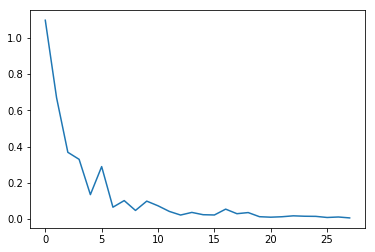

In [42]:
import matplotlib.pyplot as plt
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')

plt.show()

In [43]:
network.accuracy(X_test, y_test)

0.9120879120879121

In [47]:
import librosa
# /Users/mac/Desktop/nwcd/客户资料/001蓝拓扑/test_data/h/110.mp3
# y, sr = librosa.load('./data/test.mp3')
y, sr = librosa.load('/Users/mac/Desktop/nwcd/客户资料/001蓝拓扑/test_data/w/0.mp3')
a = librosa.feature.mfcc(y=y, sr=sr)
predict_input = np.array(get_max(a)) 

predict_input = predict_input.reshape(1, 20)
print(predict_input.shape)


/Users/mac/.local/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


(1, 20)


In [48]:
def _load(file):
    """
    输入文件名，加载数据
    :param file:文件名
    :return:浮点型数组
    """
    list = []
    f = open(file, 'r', encoding='UTF-8')
    for line in f:
        line_list = line.replace(',\n', '').split(',')
        for i in range(len(line_list)):
            line_list[i] = float(line_list[i])
        list.append(line_list)
    return np.array(list)
 
# 重新正则化
_X = _load('data/x.txt')
print(_X.shape)
print(predict_input.shape)
_X = np.concatenate( (_X, predict_input) )
print(_X.shape)

_X = normalization(_X)

# 预测最后一个新加的输入参数
network.predict(X[-1:,])
real_lable =['z', 'h', 'w']
print(network.predict(X[-1:,]))
print("x: ", real_lable[np.argmax(network.predict(X[-1:,])[0])])
# print(real_lable[np.argmax()]

 

(364, 20)
(1, 20)
(365, 20)
[[-3.8404647   9.2484415  -5.46349251]]
x:  h
